In [1]:
import numpy as np
import pandas as pd
import gc
from nltk import FreqDist
import time
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, Embedding, Bidirectional
from tensorflow.keras.optimizers import RMSprop
from keras.layers.recurrent import LSTM
from utils import *

Using TensorFlow backend.
/home/bao/miniconda3/envs/text/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bao/miniconda3/envs/text/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bao/miniconda3/envs/text/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bao/miniconda3/envs/text/l

In [2]:
input_vocab_size = 253
target_vocab_size = 110    # 1000 in full dataset
# target_vocab_size = 1000
num_samples = 100000
context_size = 3
padding_entity = [0]
self_sil_retention_percent = 0.5
X_seq_len = 60
y_seq_len = 20
hidden = 256
layers = 2
epochs = 3   # used just 1 for full dataset
batch_size = 32
val_split = 0.1
learning_rate = 0.1

## LSTM encoder/decoder for text normalization

Given a large corpus of written text aligned to its normalized spoken form, I will train an RNN to learn the correct normalization function. My model is a encoder-decoder with layers of bidirectional LSTMs.

Here is a quick summary of my model approach and architecture:

+ Character level input sequence, and word level output sequence
+ Input character vocabulary of 250 distinct characters. Output word vocabulary of 346 (the number of unique) distinct words.
+ Add a context window of 3 words to the left and right with a distinctive tag to separately identity the key token. I do this to manage the input sequence length reasonably.
+ Input sequence zero padding to a maximum of length 60. Output sequence padding to a maximum of length 20. I do this to create fixed-length sequences.
+ Model architecture with two components: an encoder and a decoder.
  - 256 hidden units in each layer of the encoder and decoder
  - Three bidirectional LSTM layers in the encoder
  - Two LSTM layers in the decoder

### 1. Create the encoder/decoder model

In [3]:
# let's make the model
import keras
model = Sequential()

# creating encoder network
model.add(Embedding(input_vocab_size+2, hidden, input_length=X_seq_len, mask_zero=True))
print('Embedding layer created')
model.add(Bidirectional(LSTM(hidden, return_sequences = True), merge_mode = 'concat'))
model.add(Bidirectional(LSTM(hidden, return_sequences = True), merge_mode = 'concat'))
model.add(Bidirectional(LSTM(hidden), merge_mode = 'concat'))
model.add(RepeatVector(y_seq_len))
print('Encoder layer created')

# creating decoder network
for _ in range(layers):
    model.add(LSTM(hidden, return_sequences=True))
model.add(TimeDistributed(Dense(target_vocab_size+1)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print('Decoder layer created')

# checking the model summary
model.summary()

Embedding layer created
Encoder layer created
Decoder layer created
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 256)           65280     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 512)           1050624   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 512)           1574912   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               1574912   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 512)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 256)           787456    
_________________________________________________________________
lstm_5 (

### 2. Load the training data and do a quick exploratory analysis

In [4]:
import pandas as pd
import time
start = time.time()

# load training data
X_train_data = pd.read_csv("ITN.csv")

X_train_data['before'] = X_train_data['before'].apply(str)
X_train_data['after'] = X_train_data['after'].apply(str)

print('Training data loaded in {0} s.'.format(time.time()-start))

print(X_train_data.shape)
X_train_data = X_train_data.iloc[:num_samples]

X_train_data.head()

Training data loaded in 0.7409770488739014 s.
(1048575, 5)


sentence_id  token_id  class         before          after
0           0       0.0  PLAIN  Brillantaisia  Brillantaisia
1           0       1.0  PLAIN             is             is
2           0       2.0  PLAIN              a              a
3           0       3.0  PLAIN          genus          genus
4           0       4.0  PLAIN             of             of

In [5]:
#exchange the input and the output
'''
import pandas as pd
df = pd.read_csv('en_train.csv')
df_reorder = df[['sentence_id', 'token_id', 'class', 'after', 'before']] # rearrange column here
df_reorder.to_csv('ITN.csv', index=False)
'''

print(X_train_data[:100])

   sentence_id  token_id     class         before          after
0            0       0.0     PLAIN  Brillantaisia  Brillantaisia
1            0       1.0     PLAIN             is             is
2            0       2.0     PLAIN              a              a
3            0       3.0     PLAIN          genus          genus
4            0       4.0     PLAIN             of             of
..         ...       ...       ...            ...            ...
95           6       3.0  CARDINAL     ninety one             91
96           6       4.0     PUNCT              (              (
97           6       5.0     PLAIN         Athens         Athens
98           6       6.0     PUNCT              —              —
99           6       7.0     PLAIN         Sounio         Sounio

[100 rows x 5 columns]


<AxesSubplot:xlabel='class', ylabel='count'>

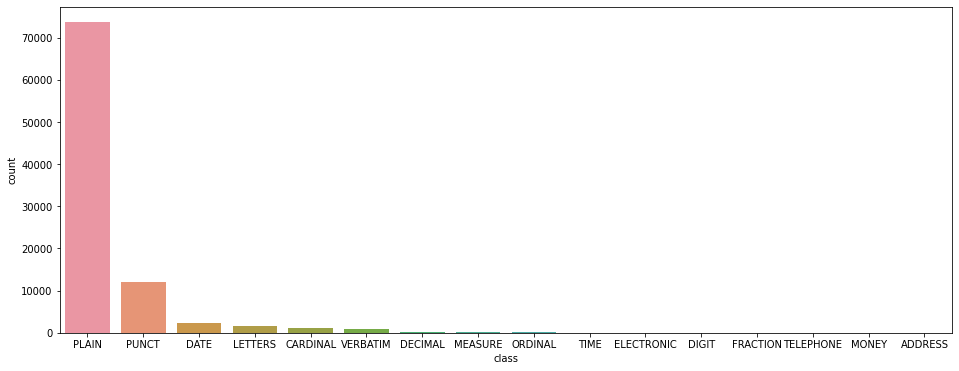

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# let's see how many training tokens fall into each class by
# plotting a count graph for the "Class" column of the data
fig = plt.figure(figsize=(16,6))
sns.countplot(x='class',data = X_train_data)

In [7]:
# the counts for number of sample tokens in each class group
X_train_data['class'].value_counts().sort_values(ascending = False)

PLAIN         73686
PUNCT         12021
DATE           2395
LETTERS        1543
CARDINAL       1163
VERBATIM        789
MEASURE         142
DECIMAL         133
ORDINAL         107
DIGIT            51
ELECTRONIC       43
TELEPHONE        37
FRACTION         16
MONEY            16
TIME             12
ADDRESS           1
Name: class, dtype: int64

### 3. Create the input and target vocabularies

These are the vocabularies that the model can draw input from and decode output to.

In [8]:
start = time.time()

# create vocabularies
# target vocab
y = list(np.where(X_train_data['class'] == "PUNCT", "sil.",
      np.where(X_train_data['before'] == X_train_data['after'], "<self>",
               X_train_data['after'])))

y = [token.split() for token in y]
#y = [list(token) for token in y]

dist = FreqDist(np.hstack(y))
temp = dist.most_common(target_vocab_size-1)
temp = [word[0] for word in temp]
temp.insert(0, 'ZERO')
temp.append('UNK')

target_vocab = {word:ix for ix, word in enumerate(temp)}
target_vocab_reversed = {ix:word for word,ix in target_vocab.items()}
print(len(target_vocab))

# input vocab
X = list(X_train_data['before'])
X = [token.split() for token in X]

dist = FreqDist(np.hstack(X))
temp = dist.most_common(input_vocab_size-1)
temp = [char[0] for char in temp]
temp.insert(0, 'ZERO')
temp.append('<norm>')
temp.append('UNK')

input_vocab = {char:ix for ix, char in enumerate(temp)}
print(len(input_vocab))

gc.collect()

print('Vocab created in {0} s.'.format(time.time()-start))
print(target_vocab)

111
255
Vocab created in 0.9390614032745361 s.
{'ZERO': 0, '<self>': 1, 'sil.': 2, '2011': 3, '2012': 4, '2010': 5, '&': 6, '2014': 7, '1': 8, '2015': 9, '2013': 10, '2': 11, '-': 12, '2009': 13, 'June': 14, '3': 15, 'May': 16, 'February': 17, '2008': 18, 'March': 19, 'April': 20, 'July': 21, 'September': 22, 'November': 23, 'August': 24, 'October': 25, '4': 26, 'December': 27, 'PDF': 28, 'January': 29, '5': 30, '2006': 31, '2007': 32, '6': 33, '10': 34, '8': 35, 'M.': 36, '2004': 37, 'J.': 38, '2005': 39, '22': 40, '21': 41, '2003': 42, '15': 43, '19': 44, '2000': 45, '30': 46, '12': 47, 'R.': 48, '20': 49, '18': 50, '2001': 51, 'A.': 52, '11': 53, '16': 54, 'S.': 55, 'U.S.': 56, 'D.': 57, '2002': 58, '28': 59, '25': 60, '13': 61, '1998': 62, '23': 63, '14': 64, '7': 65, '9': 66, '29': 67, '17': 68, '24': 69, '2016': 70, 'pp': 71, '27': 72, 'ISBN': 73, 'W.': 74, '26': 75, 'US': 76, '1994': 77, '1997': 78, 'G.': 79, '1996': 80, 'E.': 81, 'H.': 82, '1987': 83, 'C.': 84, '31': 85, 'TV': 

In [9]:
start = time.time()

# Converting input and target tokens to index values

X = index(X, input_vocab)
y = index(y, target_vocab)

gc.collect()

print('Replaced tokens with integers in {0} s.'.format(time.time()-start))

Replaced tokens with integers in 0.25490283966064453 s.


### 4. Data preprocessing

Add the context window (3 tokens previous and 3 tokens in the future) for each token of the training data. Pad these sequences to make each input sequence have a fixed length, and convert to an

In [10]:
start = time.time()

# adding a context window of 3 words in input, with token separated by <norm>
X = add_context_window(X, context_size, padding_entity, input_vocab)

print('Added context window to X in {0} s.'.format(time.time()-start))

Added context window to X in 0.6404283046722412 s.


In [11]:
start = time.time()

# padding
X = padding_batchwise(X, X_seq_len)
y = padding_batchwise(y, y_seq_len)

# convert to integer array, batch-wise (converting full data to array at once takes a lot of time)
X = np.array(X)
y = np.array(y)
y_sequences = np.asarray(sequences(y, y_seq_len, target_vocab))

print(X.shape, y_sequences.shape)

print('Added padding and converted to np array in {0} s.'.format(time.time()-start))

(100000, 60) (100000, 20, 111)
Added padding and converted to np array in 2.0792698860168457 s.


### 5. Training the LSTM encoder/decoder

I'll train 500,000 sample tokens for 5 epochs, with both model checkpointing (saving the model) after each epoch and early stop checking (stop training early if the validation accuracy gets worse- this means the model overfit!).

In [12]:
start = time.time()
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

# fitting the model on the validation data with batch size set to 128 for a total of 5 epochs:
print('Fitting model...')
checkpointer = ModelCheckpoint(filepath='saved_model.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, mode='auto')
callbacks_list = [checkpointer, earlystop]

history = model.fit(X, y_sequences, batch_size=64, epochs=1, validation_split=val_split, callbacks=callbacks_list, verbose=1)

Fitting model...
Train on 90000 samples, validate on 10000 samples
Epoch 1/1
90000/90000 [==============================] - 1428s 16ms/step - loss: 0.1403 - acc: 0.9567 - val_loss: 0.0570 - val_acc: 0.9903

Epoch 00001: val_loss improved from inf to 0.05697, saving model to saved_model.hdf5


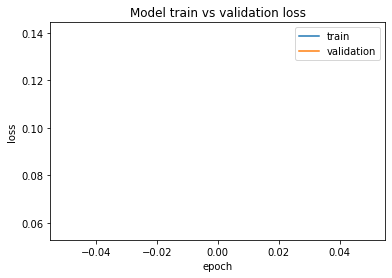

In [13]:
from matplotlib import pyplot as plt 

# let's double check that the model didn't overfit by comparing the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### 6a. Predicting text normalization for test data

I'll use my trained model to predict normalization for the full (10,000 samples) test set.

In [14]:
# load weights from training
model = load_model('saved_model.hdf5')

In [23]:
# prepare test data in the right format
X_test_data = pd.read_csv("ITN.csv")
X_test_data['before'] = X_test_data['before'].apply(str)
print(X_test_data.shape)
X_test_data = X_test_data[:3000]
print(X_test_data.shape)
X_test_data.head(100)

(1048575, 5)
(3000, 5)


sentence_id  token_id     class         before          after
0            0       0.0     PLAIN  Brillantaisia  Brillantaisia
1            0       1.0     PLAIN             is             is
2            0       2.0     PLAIN              a              a
3            0       3.0     PLAIN          genus          genus
4            0       4.0     PLAIN             of             of
..         ...       ...       ...            ...            ...
95           6       3.0  CARDINAL     ninety one             91
96           6       4.0     PUNCT              (              (
97           6       5.0     PLAIN         Athens         Athens
98           6       6.0     PUNCT              —              —
99           6       7.0     PLAIN         Sounio         Sounio

[100 rows x 5 columns]

In [24]:
X_test = list(X_test_data['before'])
X_test = [token.split() for token in X_test]

X_test = index(X_test, input_vocab) # Convert to integer index
X_test = add_context_window(X_test, context_size, padding_entity, input_vocab) # Add context window
X_test = padding_batchwise(X_test, X_seq_len) # Padding

# convert X_test to integer array, batch-wise (converting full data to array at once takes a lot of time)
# X_test = array_batchwise(X_test, X_seq_len)

In [25]:
# make predictions
test_predictions = np.argmax(model.predict(np.asarray(X_test), batch_size = 1, verbose=1), axis=2)

predicted_test_sequences = []
for prediction in test_predictions:
    sequence = ' '.join([target_vocab_reversed[index] for index in prediction if index > 0])
    predicted_test_sequences.append(sequence)
np.savetxt('test_predictions', predicted_test_sequences, fmt='%s')

3000/3000 [==============================] - 456s 152ms/step


### 6b. Investigating the model's predictions: what went wrong?

I'll focus on the "interesting" cases - where the model didn't predict <self\> or sil. These cass include dates, measures, money, and other cases that are not already trivially normalized. Per the concern I bring up in my write-up analysis that my model is only memorizing normalizations, I will also look at novel test cases that don't appear in my training data.

In [26]:
with open('test_predictions', 'r') as f:
    predicted_test_sequences = f.readlines()
    # need to get rid of "\n" from loading
    predicted_test_sequences = [pred.rstrip('\n') for pred in predicted_test_sequences]
    
pred = pd.Series(predicted_test_sequences)

X_test_data['after'] = pred.values

X_test_data.head(100)

sentence_id  token_id     class         before   after
0            0       0.0     PLAIN  Brillantaisia  <self>
1            0       1.0     PLAIN             is  <self>
2            0       2.0     PLAIN              a  <self>
3            0       3.0     PLAIN          genus  <self>
4            0       4.0     PLAIN             of  <self>
..         ...       ...       ...            ...     ...
95           6       3.0  CARDINAL     ninety one  <self>
96           6       4.0     PUNCT              (  <self>
97           6       5.0     PLAIN         Athens  <self>
98           6       6.0     PUNCT              —  <self>
99           6       7.0     PLAIN         Sounio  <self>

[100 rows x 5 columns]

In [27]:
# boring_cases = ['<self>', 'sil.']
# let's look at the interesting cases in the predicted for test data
interesting_cases = X_test_data[X_test_data['after'] != '<self>']
interesting_cases = interesting_cases[interesting_cases['after'] != 'sil.']
interesting_cases.tail(100)

Empty DataFrame
Columns: [sentence_id, token_id, class, before, after]
Index: []

In [28]:
# now let's look at the novel test cases- those that didn't appear in the training data
common = X_train_data.merge(X_test_data,on=['before'])
novel_cases = X_test_data[(~X_test_data.before.isin(common.before))]
print('There are {0} novel cases in the test set.'.format(novel_cases.shape[0]))
novel_cases.head(30)

There are 0 novel cases in the test set.


Empty DataFrame
Columns: [sentence_id, token_id, class, before, after]
Index: []

In [ ]:
# and now novel important cases
# I want to see if my model generalizes or is just memorizing the training data
novel_important_cases = novel_cases[novel_cases['after'] != '<self>']
novel_important_cases = novel_important_cases[novel_important_cases['after'] != 'sil.']
print('There are {0} novel important cases in the test set.'.format(novel_important_cases.shape[0]))
novel_important_cases.head(30)